In [1]:
import pathlib
import sys

import numpy as np
import optuna
import pandas as pd
import pyarrow.parquet as pq
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")

import json

from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
from utils.utils import df_stats

## Papermill is used for executing notebooks in the CLI with multiple parameters
Here the `injected-parameters` cell is used to inject parameters into the notebook via papermill.
This enables multiple notebooks to be executed with different parameters, preventing to manually update parameters or have multiple copies of the notebook.

In [2]:
# Parameters
CELL_TYPE = "PBMC"
CONTROL_NAME = "DMSO_0.100_DMSO_0.025"
TREATMENT_NAME = "Thapsigargin_1.000_DMSO_0.025"
MODEL_NAME = "DMSO_0.025_vs_Thapsigargin_1"
SHUFFLE = False

In [3]:
ml_configs_file = pathlib.Path("../../MLP_utils/binary_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.CONTROL_NAME = CONTROL_NAME
mlp_params.TREATMENT_NAME = TREATMENT_NAME
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

In [4]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df = pq.read_table(file_path).to_pandas()

In [5]:
# # change model name to match shuffle
# if mlp_params.SHUFFLE:
#     mlp_params.MODEL_NAME = f'{mlp_params.MODEL_NAME}_shuffle'
# elif mlp_params.SHUFFLE != True:
#     pass
# else:
#     raise ValueError('SHUFFLE must be True or False')

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [6]:
# filter the oneb_Metadata_Treatment_Dose_Inhibitor_Dose column to only include the treatment and control via loc
df = df.loc[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [mlp_params.TREATMENT_NAME, mlp_params.CONTROL_NAME]
    )
]


print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
df_stats(df)

if mlp_params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=mlp_params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_DMSO_0.025' 'Thapsigargin_1.000_DMSO_0.025']
The dimensions of the data are: (363586, 1270)


Number of total missing values across all columns: 727172
Data Subset Is Off


In [7]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['J06' 'K07']
Wells to use for training, validation, and testing ['B06' 'C06' 'B07' 'C07' 'D06' 'D07' 'I06' 'I07' 'K06' 'J07']


In [8]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [9]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

#### Split Data - All Models can proceed through this point

In [10]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=mlp_params.TRAIN_PROPORTION_SPLIT,
    val_proportion=mlp_params.VALIDATION_PROPORTION_SPLIT,
    test_proportion=mlp_params.TEST_PROPORTION_SPLIT,
    # train_proportion=0.8,
    # val_proportion=0.1,
    # test_proportion=0.1,
    seed=0,
    params=mlp_params,
)

In [11]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [12]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1245
Number of out features:  2
Binary_Classification


In [13]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

In [14]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

Adam


Epoch 0: Validation loss decreased (inf --> 0.537551).  Saving model ...
	 Train_Loss: 0.6063 Train_Acc: 66.639 Val_Loss: 0.5376  BEST VAL Loss: 0.5376  Val_Acc: 72.850



Epoch 1: Validation loss decreased (0.537551 --> 0.517355).  Saving model ...
	 Train_Loss: 0.5713 Train_Acc: 71.907 Val_Loss: 0.5174  BEST VAL Loss: 0.5174  Val_Acc: 77.057



Epoch 2: Validation loss decreased (0.517355 --> 0.496339).  Saving model ...
	 Train_Loss: 0.5491 Train_Acc: 74.114 Val_Loss: 0.4963  BEST VAL Loss: 0.4963  Val_Acc: 78.446



Epoch 3: Validation loss decreased (0.496339 --> 0.482212).  Saving model ...
	 Train_Loss: 0.5328 Train_Acc: 75.904 Val_Loss: 0.4822  BEST VAL Loss: 0.4822  Val_Acc: 80.259



Epoch 4: Validation loss decreased (0.482212 --> 0.469090).  Saving model ...
	 Train_Loss: 0.5196 Train_Acc: 77.060 Val_Loss: 0.4691  BEST VAL Loss: 0.4691  Val_Acc: 80.730



Epoch 5: Validation loss decreased (0.469090 --> 0.458745).  Saving model ...
	 Train_Loss: 0.5088 Train_Acc: 77.999 Val_Loss: 0.4587  BEST VAL Loss: 0.4587  Val_Acc: 81.443



Epoch 6: Validation loss decreased (0.458745 --> 0.450053).  Saving model ...
	 Train_Loss: 0.4997 Train_Acc: 78.623 Val_Loss: 0.4501  BEST VAL Loss: 0.4501  Val_Acc: 82.526



Epoch 7: Validation loss decreased (0.450053 --> 0.442957).  Saving model ...
	 Train_Loss: 0.4916 Train_Acc: 79.448 Val_Loss: 0.4430  BEST VAL Loss: 0.4430  Val_Acc: 82.717



Epoch 8: Validation loss decreased (0.442957 --> 0.435997).  Saving model ...
	 Train_Loss: 0.4845 Train_Acc: 79.838 Val_Loss: 0.4360  BEST VAL Loss: 0.4360  Val_Acc: 83.057



Epoch 9: Validation loss decreased (0.435997 --> 0.430781).  Saving model ...
	 Train_Loss: 0.4786 Train_Acc: 79.940 Val_Loss: 0.4308  BEST VAL Loss: 0.4308  Val_Acc: 82.956



Epoch 10: Validation loss decreased (0.430781 --> 0.425800).  Saving model ...
	 Train_Loss: 0.4733 Train_Acc: 80.344 Val_Loss: 0.4258  BEST VAL Loss: 0.4258  Val_Acc: 83.612



Epoch 11: Validation loss decreased (0.425800 --> 0.420850).  Saving model ...
	 Train_Loss: 0.4686 Train_Acc: 80.543 Val_Loss: 0.4209  BEST VAL Loss: 0.4209  Val_Acc: 83.427



Epoch 12: Validation loss decreased (0.420850 --> 0.416920).  Saving model ...
	 Train_Loss: 0.4642 Train_Acc: 80.740 Val_Loss: 0.4169  BEST VAL Loss: 0.4169  Val_Acc: 83.138



Epoch 13: Validation loss decreased (0.416920 --> 0.413436).  Saving model ...
	 Train_Loss: 0.4604 Train_Acc: 80.998 Val_Loss: 0.4134  BEST VAL Loss: 0.4134  Val_Acc: 83.487



Epoch 14: Validation loss decreased (0.413436 --> 0.409805).  Saving model ...
	 Train_Loss: 0.4569 Train_Acc: 81.207 Val_Loss: 0.4098  BEST VAL Loss: 0.4098  Val_Acc: 83.605



Epoch 15: Validation loss decreased (0.409805 --> 0.406569).  Saving model ...
	 Train_Loss: 0.4536 Train_Acc: 81.322 Val_Loss: 0.4066  BEST VAL Loss: 0.4066  Val_Acc: 83.757



Epoch 16: Validation loss decreased (0.406569 --> 0.403995).  Saving model ...
	 Train_Loss: 0.4507 Train_Acc: 81.390 Val_Loss: 0.4040  BEST VAL Loss: 0.4040  Val_Acc: 83.683



Epoch 17: Validation loss decreased (0.403995 --> 0.401615).  Saving model ...
	 Train_Loss: 0.4479 Train_Acc: 81.499 Val_Loss: 0.4016  BEST VAL Loss: 0.4016  Val_Acc: 84.288



Epoch 18: Validation loss decreased (0.401615 --> 0.399551).  Saving model ...
	 Train_Loss: 0.4454 Train_Acc: 81.543 Val_Loss: 0.3996  BEST VAL Loss: 0.3996  Val_Acc: 83.447



Epoch 19: Validation loss decreased (0.399551 --> 0.398091).  Saving model ...
	 Train_Loss: 0.4430 Train_Acc: 81.624 Val_Loss: 0.3981  BEST VAL Loss: 0.3981  Val_Acc: 83.857



Epoch 20: Validation loss decreased (0.398091 --> 0.396582).  Saving model ...
	 Train_Loss: 0.4408 Train_Acc: 81.721 Val_Loss: 0.3966  BEST VAL Loss: 0.3966  Val_Acc: 84.194



Epoch 21: Validation loss decreased (0.396582 --> 0.395292).  Saving model ...
	 Train_Loss: 0.4387 Train_Acc: 81.836 Val_Loss: 0.3953  BEST VAL Loss: 0.3953  Val_Acc: 83.464



Epoch 22: Validation loss decreased (0.395292 --> 0.393636).  Saving model ...
	 Train_Loss: 0.4367 Train_Acc: 81.815 Val_Loss: 0.3936  BEST VAL Loss: 0.3936  Val_Acc: 83.911



Epoch 23: Validation loss decreased (0.393636 --> 0.391792).  Saving model ...
	 Train_Loss: 0.4349 Train_Acc: 81.945 Val_Loss: 0.3918  BEST VAL Loss: 0.3918  Val_Acc: 84.046



Epoch 24: Validation loss decreased (0.391792 --> 0.390258).  Saving model ...
	 Train_Loss: 0.4332 Train_Acc: 82.000 Val_Loss: 0.3903  BEST VAL Loss: 0.3903  Val_Acc: 83.894



Epoch 25: Validation loss decreased (0.390258 --> 0.389057).  Saving model ...
	 Train_Loss: 0.4317 Train_Acc: 82.038 Val_Loss: 0.3891  BEST VAL Loss: 0.3891  Val_Acc: 83.810



Epoch 26: Validation loss decreased (0.389057 --> 0.387617).  Saving model ...
	 Train_Loss: 0.4302 Train_Acc: 81.976 Val_Loss: 0.3876  BEST VAL Loss: 0.3876  Val_Acc: 83.894



Epoch 27: Validation loss decreased (0.387617 --> 0.386392).  Saving model ...
	 Train_Loss: 0.4288 Train_Acc: 82.059 Val_Loss: 0.3864  BEST VAL Loss: 0.3864  Val_Acc: 83.619



Epoch 28: Validation loss decreased (0.386392 --> 0.385017).  Saving model ...
	 Train_Loss: 0.4274 Train_Acc: 82.160 Val_Loss: 0.3850  BEST VAL Loss: 0.3850  Val_Acc: 84.436



Epoch 29: Validation loss decreased (0.385017 --> 0.384031).  Saving model ...
	 Train_Loss: 0.4262 Train_Acc: 82.014 Val_Loss: 0.3840  BEST VAL Loss: 0.3840  Val_Acc: 83.659



Epoch 30: Validation loss decreased (0.384031 --> 0.382917).  Saving model ...
	 Train_Loss: 0.4250 Train_Acc: 82.218 Val_Loss: 0.3829  BEST VAL Loss: 0.3829  Val_Acc: 84.086



Epoch 31: Validation loss decreased (0.382917 --> 0.381972).  Saving model ...
	 Train_Loss: 0.4239 Train_Acc: 82.173 Val_Loss: 0.3820  BEST VAL Loss: 0.3820  Val_Acc: 84.079



Epoch 32: Validation loss decreased (0.381972 --> 0.381026).  Saving model ...
	 Train_Loss: 0.4228 Train_Acc: 82.230 Val_Loss: 0.3810  BEST VAL Loss: 0.3810  Val_Acc: 84.197



Epoch 33: Validation loss decreased (0.381026 --> 0.380369).  Saving model ...
	 Train_Loss: 0.4217 Train_Acc: 82.368 Val_Loss: 0.3804  BEST VAL Loss: 0.3804  Val_Acc: 83.699



Epoch 34: Validation loss decreased (0.380369 --> 0.379728).  Saving model ...
	 Train_Loss: 0.4208 Train_Acc: 82.141 Val_Loss: 0.3797  BEST VAL Loss: 0.3797  Val_Acc: 84.200



Epoch 35: Validation loss decreased (0.379728 --> 0.379031).  Saving model ...
	 Train_Loss: 0.4199 Train_Acc: 82.168 Val_Loss: 0.3790  BEST VAL Loss: 0.3790  Val_Acc: 83.955



Epoch 36: Validation loss decreased (0.379031 --> 0.378282).  Saving model ...
	 Train_Loss: 0.4190 Train_Acc: 82.228 Val_Loss: 0.3783  BEST VAL Loss: 0.3783  Val_Acc: 83.814



Epoch 37: Validation loss decreased (0.378282 --> 0.377679).  Saving model ...
	 Train_Loss: 0.4182 Train_Acc: 82.148 Val_Loss: 0.3777  BEST VAL Loss: 0.3777  Val_Acc: 83.814



Epoch 38: Validation loss decreased (0.377679 --> 0.377258).  Saving model ...
	 Train_Loss: 0.4173 Train_Acc: 82.288 Val_Loss: 0.3773  BEST VAL Loss: 0.3773  Val_Acc: 83.760



Epoch 39: Validation loss decreased (0.377258 --> 0.376763).  Saving model ...
	 Train_Loss: 0.4165 Train_Acc: 82.276 Val_Loss: 0.3768  BEST VAL Loss: 0.3768  Val_Acc: 83.612



Epoch 40: Validation loss decreased (0.376763 --> 0.376226).  Saving model ...
	 Train_Loss: 0.4158 Train_Acc: 82.379 Val_Loss: 0.3762  BEST VAL Loss: 0.3762  Val_Acc: 83.323



Epoch 41: Validation loss decreased (0.376226 --> 0.375567).  Saving model ...
	 Train_Loss: 0.4150 Train_Acc: 82.434 Val_Loss: 0.3756  BEST VAL Loss: 0.3756  Val_Acc: 84.359



Epoch 42: Validation loss decreased (0.375567 --> 0.374944).  Saving model ...
	 Train_Loss: 0.4143 Train_Acc: 82.339 Val_Loss: 0.3749  BEST VAL Loss: 0.3749  Val_Acc: 83.588



Epoch 43: Validation loss decreased (0.374944 --> 0.374364).  Saving model ...
	 Train_Loss: 0.4136 Train_Acc: 82.540 Val_Loss: 0.3744  BEST VAL Loss: 0.3744  Val_Acc: 84.426



Epoch 44: Validation loss decreased (0.374364 --> 0.373895).  Saving model ...
	 Train_Loss: 0.4129 Train_Acc: 82.540 Val_Loss: 0.3739  BEST VAL Loss: 0.3739  Val_Acc: 84.184



Epoch 45: Validation loss decreased (0.373895 --> 0.373292).  Saving model ...
	 Train_Loss: 0.4122 Train_Acc: 82.461 Val_Loss: 0.3733  BEST VAL Loss: 0.3733  Val_Acc: 84.372



Epoch 46: Validation loss decreased (0.373292 --> 0.372750).  Saving model ...
	 Train_Loss: 0.4116 Train_Acc: 82.590 Val_Loss: 0.3728  BEST VAL Loss: 0.3728  Val_Acc: 84.359



Epoch 47: Validation loss decreased (0.372750 --> 0.372491).  Saving model ...
	 Train_Loss: 0.4109 Train_Acc: 82.616 Val_Loss: 0.3725  BEST VAL Loss: 0.3725  Val_Acc: 83.632



Epoch 48: Validation loss decreased (0.372491 --> 0.372074).  Saving model ...
	 Train_Loss: 0.4103 Train_Acc: 82.607 Val_Loss: 0.3721  BEST VAL Loss: 0.3721  Val_Acc: 84.264



Epoch 49: Validation loss decreased (0.372074 --> 0.371636).  Saving model ...
	 Train_Loss: 0.4097 Train_Acc: 82.617 Val_Loss: 0.3716  BEST VAL Loss: 0.3716  Val_Acc: 84.604



Epoch 50: Validation loss decreased (0.371636 --> 0.371014).  Saving model ...
	 Train_Loss: 0.4091 Train_Acc: 82.638 Val_Loss: 0.3710  BEST VAL Loss: 0.3710  Val_Acc: 84.567



Epoch 51: Validation loss decreased (0.371014 --> 0.370600).  Saving model ...
	 Train_Loss: 0.4086 Train_Acc: 82.309 Val_Loss: 0.3706  BEST VAL Loss: 0.3706  Val_Acc: 84.422



Epoch 52: Validation loss decreased (0.370600 --> 0.370379).  Saving model ...
	 Train_Loss: 0.4081 Train_Acc: 82.596 Val_Loss: 0.3704  BEST VAL Loss: 0.3704  Val_Acc: 84.308



Epoch 53: Validation loss decreased (0.370379 --> 0.369968).  Saving model ...
	 Train_Loss: 0.4076 Train_Acc: 82.490 Val_Loss: 0.3700  BEST VAL Loss: 0.3700  Val_Acc: 84.382



Epoch 54: Validation loss decreased (0.369968 --> 0.369371).  Saving model ...
	 Train_Loss: 0.4071 Train_Acc: 82.556 Val_Loss: 0.3694  BEST VAL Loss: 0.3694  Val_Acc: 84.782



Epoch 55: Validation loss decreased (0.369371 --> 0.369007).  Saving model ...
	 Train_Loss: 0.4067 Train_Acc: 82.541 Val_Loss: 0.3690  BEST VAL Loss: 0.3690  Val_Acc: 84.042



Epoch 56: Validation loss decreased (0.369007 --> 0.368643).  Saving model ...
	 Train_Loss: 0.4062 Train_Acc: 82.539 Val_Loss: 0.3686  BEST VAL Loss: 0.3686  Val_Acc: 84.547



Epoch 57: Validation loss decreased (0.368643 --> 0.368283).  Saving model ...
	 Train_Loss: 0.4058 Train_Acc: 82.652 Val_Loss: 0.3683  BEST VAL Loss: 0.3683  Val_Acc: 84.143



Epoch 58: Validation loss decreased (0.368283 --> 0.367911).  Saving model ...
	 Train_Loss: 0.4053 Train_Acc: 82.565 Val_Loss: 0.3679  BEST VAL Loss: 0.3679  Val_Acc: 84.422



Epoch 59: Validation loss decreased (0.367911 --> 0.367553).  Saving model ...
	 Train_Loss: 0.4048 Train_Acc: 82.834 Val_Loss: 0.3676  BEST VAL Loss: 0.3676  Val_Acc: 84.624



Epoch 60: Validation loss decreased (0.367553 --> 0.367410).  Saving model ...
	 Train_Loss: 0.4044 Train_Acc: 82.560 Val_Loss: 0.3674  BEST VAL Loss: 0.3674  Val_Acc: 84.570



Epoch 61: Validation loss decreased (0.367410 --> 0.367027).  Saving model ...
	 Train_Loss: 0.4040 Train_Acc: 82.805 Val_Loss: 0.3670  BEST VAL Loss: 0.3670  Val_Acc: 84.395



Epoch 62: Validation loss decreased (0.367027 --> 0.366670).  Saving model ...
	 Train_Loss: 0.4036 Train_Acc: 82.860 Val_Loss: 0.3667  BEST VAL Loss: 0.3667  Val_Acc: 84.338



Epoch 63: Validation loss decreased (0.366670 --> 0.366442).  Saving model ...
	 Train_Loss: 0.4031 Train_Acc: 82.746 Val_Loss: 0.3664  BEST VAL Loss: 0.3664  Val_Acc: 84.170



Epoch 64: Validation loss decreased (0.366442 --> 0.366282).  Saving model ...
	 Train_Loss: 0.4027 Train_Acc: 82.786 Val_Loss: 0.3663  BEST VAL Loss: 0.3663  Val_Acc: 84.570



Epoch 65: Validation loss decreased (0.366282 --> 0.365925).  Saving model ...
	 Train_Loss: 0.4024 Train_Acc: 82.637 Val_Loss: 0.3659  BEST VAL Loss: 0.3659  Val_Acc: 84.490



Epoch 66: Validation loss decreased (0.365925 --> 0.365838).  Saving model ...
	 Train_Loss: 0.4020 Train_Acc: 82.730 Val_Loss: 0.3658  BEST VAL Loss: 0.3658  Val_Acc: 84.089



Epoch 67: Validation loss decreased (0.365838 --> 0.365532).  Saving model ...
	 Train_Loss: 0.4017 Train_Acc: 82.419 Val_Loss: 0.3655  BEST VAL Loss: 0.3655  Val_Acc: 84.254



Epoch 68: Validation loss decreased (0.365532 --> 0.365506).  Saving model ...
	 Train_Loss: 0.4014 Train_Acc: 82.555 Val_Loss: 0.3655  BEST VAL Loss: 0.3655  Val_Acc: 83.978



Epoch 69: Validation loss decreased (0.365506 --> 0.365232).  Saving model ...
	 Train_Loss: 0.4011 Train_Acc: 82.472 Val_Loss: 0.3652  BEST VAL Loss: 0.3652  Val_Acc: 84.184



Epoch 70: Validation loss decreased (0.365232 --> 0.364951).  Saving model ...
	 Train_Loss: 0.4008 Train_Acc: 82.676 Val_Loss: 0.3650  BEST VAL Loss: 0.3650  Val_Acc: 84.574



Epoch 71: Validation loss decreased (0.364951 --> 0.364556).  Saving model ...
	 Train_Loss: 0.4004 Train_Acc: 82.891 Val_Loss: 0.3646  BEST VAL Loss: 0.3646  Val_Acc: 84.698



Epoch 72: Validation loss decreased (0.364556 --> 0.364229).  Saving model ...
	 Train_Loss: 0.4001 Train_Acc: 82.857 Val_Loss: 0.3642  BEST VAL Loss: 0.3642  Val_Acc: 84.883



Epoch 73: Validation loss decreased (0.364229 --> 0.364015).  Saving model ...
	 Train_Loss: 0.3998 Train_Acc: 82.614 Val_Loss: 0.3640  BEST VAL Loss: 0.3640  Val_Acc: 84.765



Epoch 74: Validation loss decreased (0.364015 --> 0.363746).  Saving model ...
	 Train_Loss: 0.3995 Train_Acc: 82.877 Val_Loss: 0.3637  BEST VAL Loss: 0.3637  Val_Acc: 84.725



Epoch 75: Validation loss decreased (0.363746 --> 0.363522).  Saving model ...
	 Train_Loss: 0.3991 Train_Acc: 82.787 Val_Loss: 0.3635  BEST VAL Loss: 0.3635  Val_Acc: 84.705



Epoch 76: Validation loss decreased (0.363522 --> 0.363414).  Saving model ...
	 Train_Loss: 0.3989 Train_Acc: 82.699 Val_Loss: 0.3634  BEST VAL Loss: 0.3634  Val_Acc: 84.523



Epoch 77: Validation loss decreased (0.363414 --> 0.363124).  Saving model ...
	 Train_Loss: 0.3986 Train_Acc: 82.768 Val_Loss: 0.3631  BEST VAL Loss: 0.3631  Val_Acc: 84.927



Epoch 78: Validation loss decreased (0.363124 --> 0.362940).  Saving model ...
	 Train_Loss: 0.3982 Train_Acc: 82.971 Val_Loss: 0.3629  BEST VAL Loss: 0.3629  Val_Acc: 84.611



Epoch 79: Validation loss decreased (0.362940 --> 0.362697).  Saving model ...
	 Train_Loss: 0.3979 Train_Acc: 82.762 Val_Loss: 0.3627  BEST VAL Loss: 0.3627  Val_Acc: 84.856



Epoch 80: Validation loss decreased (0.362697 --> 0.362572).  Saving model ...
	 Train_Loss: 0.3977 Train_Acc: 82.866 Val_Loss: 0.3626  BEST VAL Loss: 0.3626  Val_Acc: 84.846



Epoch 81: Validation loss decreased (0.362572 --> 0.362331).  Saving model ...
	 Train_Loss: 0.3974 Train_Acc: 82.847 Val_Loss: 0.3623  BEST VAL Loss: 0.3623  Val_Acc: 84.695



Epoch 82: Validation loss decreased (0.362331 --> 0.362114).  Saving model ...
	 Train_Loss: 0.3971 Train_Acc: 83.043 Val_Loss: 0.3621  BEST VAL Loss: 0.3621  Val_Acc: 84.752



Epoch 83: Validation loss decreased (0.362114 --> 0.361970).  Saving model ...
	 Train_Loss: 0.3968 Train_Acc: 82.983 Val_Loss: 0.3620  BEST VAL Loss: 0.3620  Val_Acc: 84.833



Epoch 84: Validation loss decreased (0.361970 --> 0.361801).  Saving model ...
	 Train_Loss: 0.3965 Train_Acc: 82.951 Val_Loss: 0.3618  BEST VAL Loss: 0.3618  Val_Acc: 84.406



Epoch 85: Validation loss decreased (0.361801 --> 0.361592).  Saving model ...
	 Train_Loss: 0.3962 Train_Acc: 82.915 Val_Loss: 0.3616  BEST VAL Loss: 0.3616  Val_Acc: 84.813



Epoch 86: Validation loss decreased (0.361592 --> 0.361437).  Saving model ...
	 Train_Loss: 0.3960 Train_Acc: 82.927 Val_Loss: 0.3614  BEST VAL Loss: 0.3614  Val_Acc: 84.453



Epoch 87: Validation loss decreased (0.361437 --> 0.361129).  Saving model ...
	 Train_Loss: 0.3958 Train_Acc: 82.858 Val_Loss: 0.3611  BEST VAL Loss: 0.3611  Val_Acc: 85.068



Epoch 88: Validation loss decreased (0.361129 --> 0.360907).  Saving model ...
	 Train_Loss: 0.3955 Train_Acc: 82.914 Val_Loss: 0.3609  BEST VAL Loss: 0.3609  Val_Acc: 84.772



Epoch 89: Validation loss decreased (0.360907 --> 0.360639).  Saving model ...
	 Train_Loss: 0.3953 Train_Acc: 82.939 Val_Loss: 0.3606  BEST VAL Loss: 0.3606  Val_Acc: 85.145



Epoch 90: Validation loss decreased (0.360639 --> 0.360495).  Saving model ...
	 Train_Loss: 0.3950 Train_Acc: 82.880 Val_Loss: 0.3605  BEST VAL Loss: 0.3605  Val_Acc: 84.153



Epoch 91: Validation loss decreased (0.360495 --> 0.360452).  Saving model ...
	 Train_Loss: 0.3948 Train_Acc: 82.851 Val_Loss: 0.3605  BEST VAL Loss: 0.3605  Val_Acc: 84.624



Epoch 92: Validation loss decreased (0.360452 --> 0.360251).  Saving model ...
	 Train_Loss: 0.3946 Train_Acc: 82.697 Val_Loss: 0.3603  BEST VAL Loss: 0.3603  Val_Acc: 84.574



Epoch 93: Validation loss decreased (0.360251 --> 0.360048).  Saving model ...
	 Train_Loss: 0.3943 Train_Acc: 82.912 Val_Loss: 0.3600  BEST VAL Loss: 0.3600  Val_Acc: 84.631



Epoch 94: Validation loss decreased (0.360048 --> 0.359918).  Saving model ...
	 Train_Loss: 0.3941 Train_Acc: 82.923 Val_Loss: 0.3599  BEST VAL Loss: 0.3599  Val_Acc: 84.668



Epoch 95: Validation loss decreased (0.359918 --> 0.359778).  Saving model ...
	 Train_Loss: 0.3939 Train_Acc: 83.012 Val_Loss: 0.3598  BEST VAL Loss: 0.3598  Val_Acc: 84.923



Epoch 96: Validation loss decreased (0.359778 --> 0.359529).  Saving model ...
	 Train_Loss: 0.3936 Train_Acc: 82.991 Val_Loss: 0.3595  BEST VAL Loss: 0.3595  Val_Acc: 84.984



Epoch 97: Validation loss decreased (0.359529 --> 0.359349).  Saving model ...
	 Train_Loss: 0.3934 Train_Acc: 82.918 Val_Loss: 0.3593  BEST VAL Loss: 0.3593  Val_Acc: 84.577



Epoch 98: Validation loss decreased (0.359349 --> 0.359209).  Saving model ...
	 Train_Loss: 0.3932 Train_Acc: 82.968 Val_Loss: 0.3592  BEST VAL Loss: 0.3592  Val_Acc: 84.762



Epoch 99: Validation loss decreased (0.359209 --> 0.359047).  Saving model ...
	 Train_Loss: 0.3930 Train_Acc: 82.931 Val_Loss: 0.3590  BEST VAL Loss: 0.3590  Val_Acc: 84.486



In [15]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "treatments_tested",
        "model",
        "group",
        "shuffled_data",
        "PR_Threshold",
        "Precision",
        "Recall",
    ]
)
model_stats_df

,treatments_tested,model,group,shuffled_data,PR_Threshold,Precision,Recall


/gpfs/alpine1/scratch/mlippincott@xsede.org/pyroptosis_signature_data_analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:997: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/gpfs/alpine1/scratch/mlippincott@xsede.org/pyroptosis_signature_data_analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:998: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


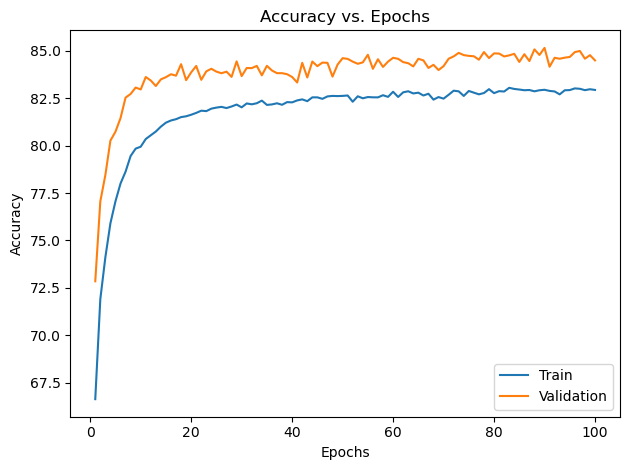

In [16]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/gpfs/alpine1/scratch/mlippincott@xsede.org/pyroptosis_signature_data_analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:997: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/gpfs/alpine1/scratch/mlippincott@xsede.org/pyroptosis_signature_data_analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:998: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


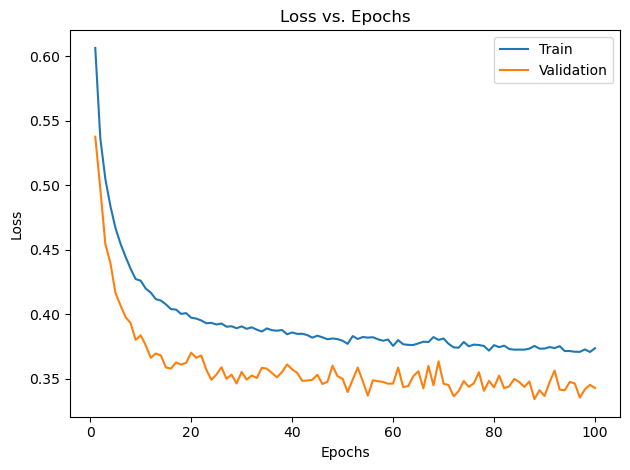

In [17]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

In [18]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_Thapsigargin_1


In [19]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_train,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89    149884
           1       0.85      0.75      0.80     87993

    accuracy                           0.86    237877
   macro avg       0.86      0.84      0.85    237877
weighted avg       0.86      0.86      0.86    237877



In [20]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [21]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_Thapsigargin_1


In [22]:
mlp_params.SHUFFLE

False

In [23]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_val,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_validation",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     18736
           1       0.83      0.73      0.78     10999

    accuracy                           0.84     29735
   macro avg       0.84      0.82      0.83     29735
weighted avg       0.84      0.84      0.84     29735



In [24]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [25]:
mlp_params.MODEL_NAME

'DMSO_0.025_vs_Thapsigargin_1'

In [26]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_Thapsigargin_1


              precision    recall  f1-score   support

           0       0.85      0.91      0.88     18736
           1       0.83      0.73      0.78     10999

    accuracy                           0.84     29735
   macro avg       0.84      0.82      0.83     29735
weighted avg       0.84      0.84      0.84     29735



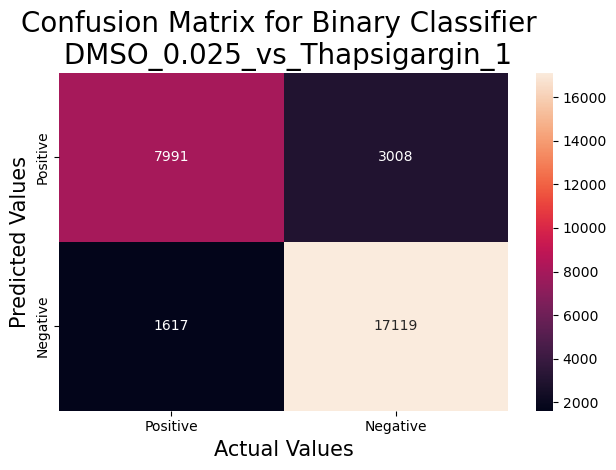

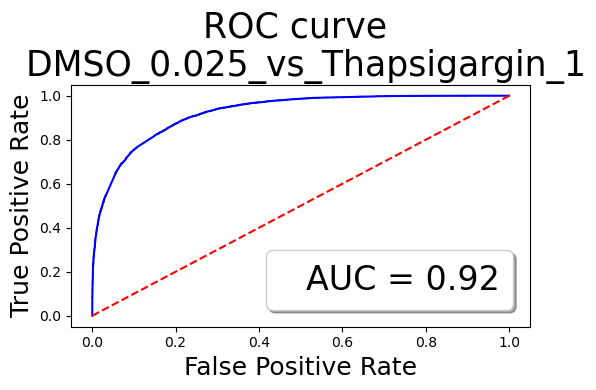

In [27]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [28]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_test,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_test",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     18736
           1       0.83      0.73      0.78     10999

    accuracy                           0.84     29735
   macro avg       0.84      0.82      0.83     29735
weighted avg       0.84      0.84      0.84     29735



In [29]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

## Test the hold out wells

In [30]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [31]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

DMSO_0.025_vs_Thapsigargin_1


              precision    recall  f1-score   support

           0       0.74      0.83      0.78     27774
           1       0.87      0.79      0.83     38465

    accuracy                           0.81     66239
   macro avg       0.80      0.81      0.81     66239
weighted avg       0.81      0.81      0.81     66239



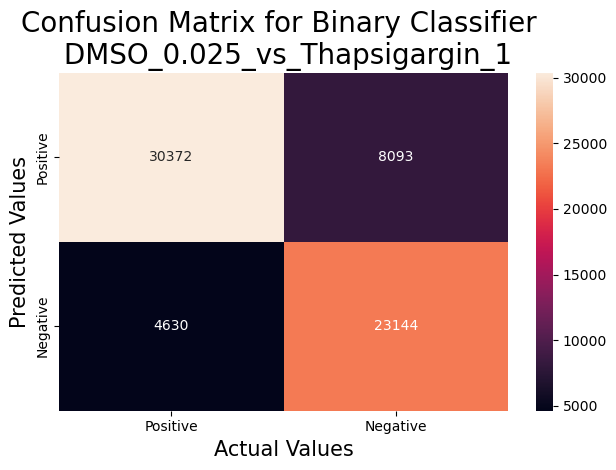

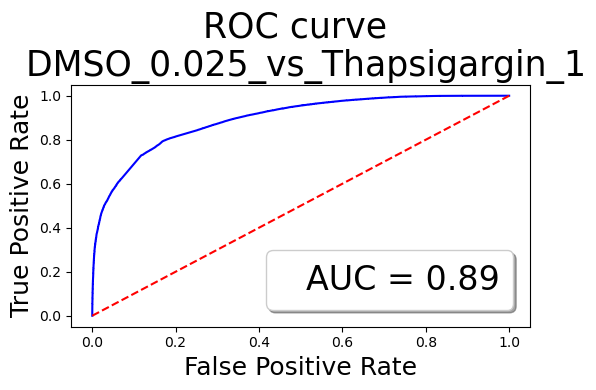

In [32]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        df_values_Y,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        df_values_Y,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [33]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    df_values_Y,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_hold_out",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.74      0.83      0.78     27774
           1       0.87      0.79      0.83     38465

    accuracy                           0.81     66239
   macro avg       0.80      0.81      0.81     66239
weighted avg       0.81      0.81      0.81     66239



In [34]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [35]:
model_stats_df

,treatments_tested,model,group,shuffled_data,PR_Threshold,Precision,Recall
0,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.369910,1.000000
1,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.370015,1.000000
2,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.370017,1.000000
3,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.370019,1.000000
4,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.370020,1.000000
...,...,...,...,...,...,...,...
58723,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,0.999249,0.400000,0.000052
58724,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,0.999795,0.500000,0.000052
58725,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,0.999818,0.666667,0.000052
58726,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,1.0,1.000000,0.000052


In [36]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    model_stats_df.to_csv(metrics_file, index=False)